In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
#from astropy.cosmology import units as cu
from astropy import constants as const
from scipy.signal import unit_impulse
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 15

In [3]:
# consts
G=const.G
mu=1 # mean molecular weight, 1 for hydrogen gas, unitless 
m_p=const.m_p
k_B=const.k_B

# for heating rate
m_b = m_p



In [4]:
# put in Mpc/h to mimic ACT paper (amodeo)
rs = np.geomspace(0.001,10,num=1000) * u.Mpc#/cu.littleh


In [5]:
class Gas:
    gamma = np.linspace(1, 3, num=6)
    def __init__(self, potential, density):
        self.potential = potential
        self.density = density
    
    def temperature(self): # gamma polytropic index
        return 1/k_B * mu * m_p * np.outer((1-self.gamma)/self.gamma, self.potential)
    
    def pressure(self):
        return k_B/(mu*m_p) * np.multiply(self.temperature(), self.density[:, None].T)
        
    def plot(self): 

        plt.figure(1)
        plt.xlabel(f'R ({rs.unit})')
        potential = self.potential.to((u.Mpc)**2/(u.s)**2)
        plt.ylabel(f'Potential ({potential.unit})')
        plt.plot(rs, potential)
        
        plt.figure(2)
        plt.xlabel(f'R ({rs.unit})')
        temperatures = self.temperature().to(u.K)
        plt.ylabel(f'Temperature ({temperatures.unit})')
        for row_idx in range (0, temperatures.shape[0]):
            plt.plot(rs, temperatures[row_idx], label=f'gamma = {self.gamma[row_idx]}')
        plt.legend()

        plt.figure(3)
        plt.xlabel(f'R ({rs.unit})')
        plt.ylabel(f'Density ({self.density.unit})')
        plt.loglog(rs, self.density)

        plt.figure(4)
        plt.xlabel(f'R ({rs.unit})')
        pressures = self.pressure().to(u.Msun/(u.Mpc*u.s**2))
        plt.ylabel(f'Pressure ({pressures.unit})')
        for row_idx in range (0, pressures.shape[0]):
            plt.loglog(rs, pressures[row_idx], label=f'gamma = {self.gamma[row_idx]}')
        plt.legend()


    

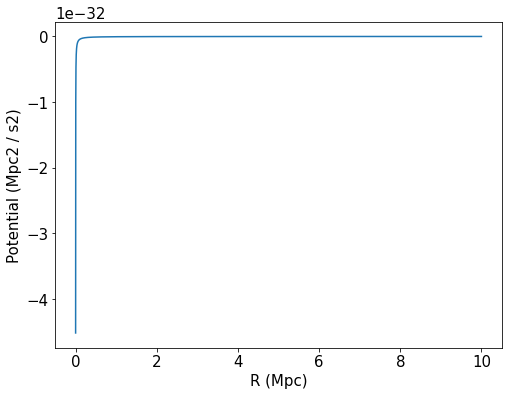

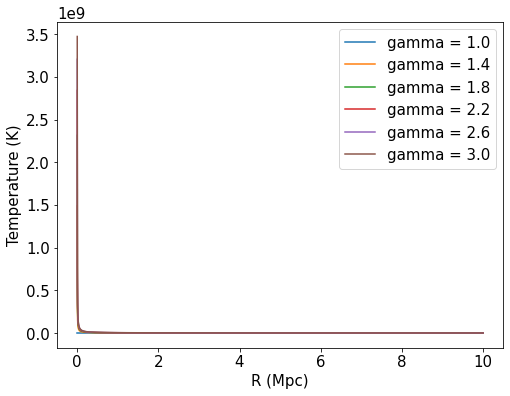

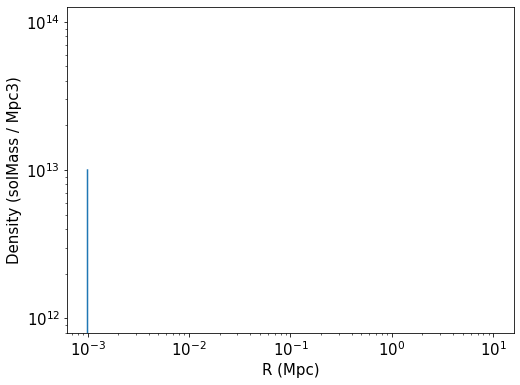

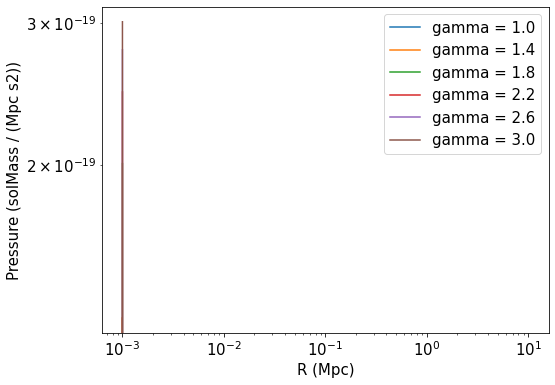

In [6]:
#for a point source
M=1*10**13 * u.Msun 
ps_potential = -G*M/rs
ps_density = unit_impulse(1000) * M/(u.Mpc)**3 # UNITS. this is not actually a dirac delta but it should be
ps_gas = Gas(ps_potential, ps_density)

ps_gas.plot()

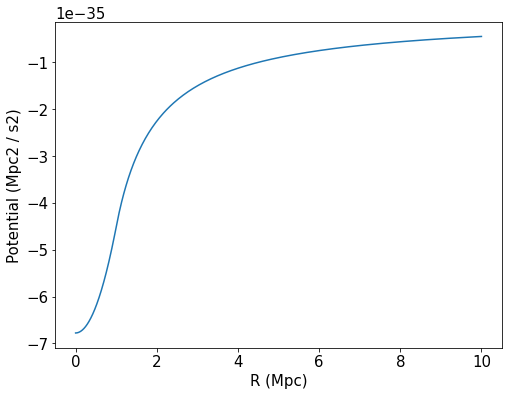

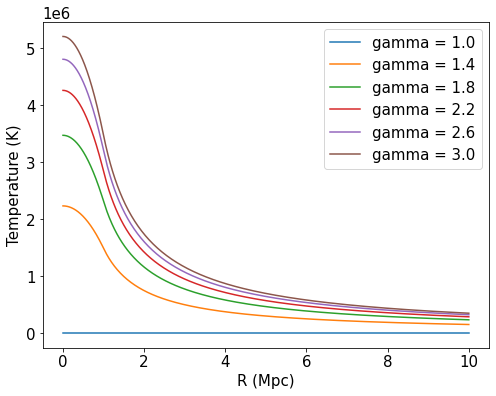

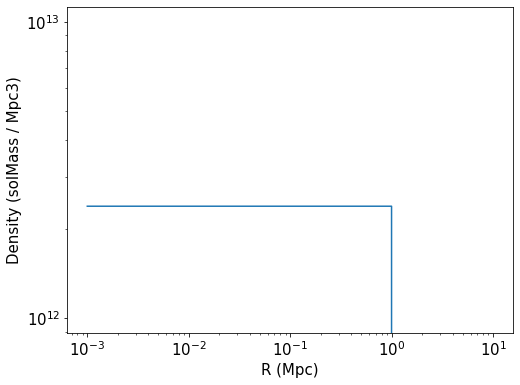

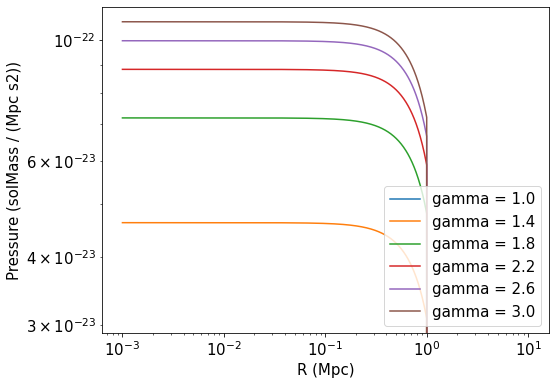

In [7]:
#for a uniform density sphere of radius a
M=1*10**13 * u.Msun 
a=1 * u.Mpc#/cu.littleh 
rho=3*M/(4*np.pi*a**3)
sph_potential = np.piecewise(rs, [rs<=a, rs>a], 
    [lambda rs: -2*np.pi*G*rho*(a**2-(rs**2)/3), lambda rs: -4*np.pi*G*rho*a**3/(3*rs)])
sph_density = np.piecewise(rs, [rs<=a, rs>a], [lambda rs: rho, lambda rs: 0])


sph_gas = Gas(sph_potential, sph_density)
sph_gas.plot()

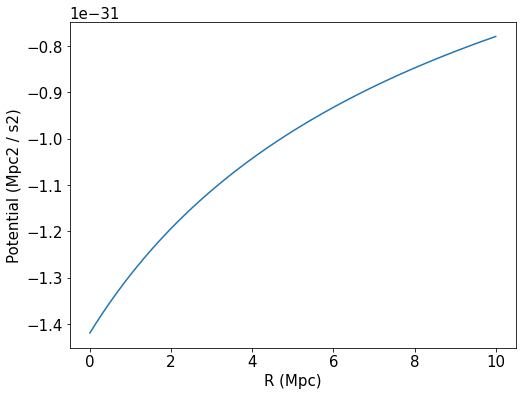

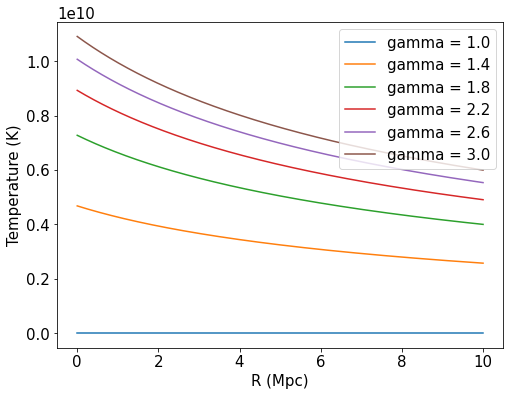

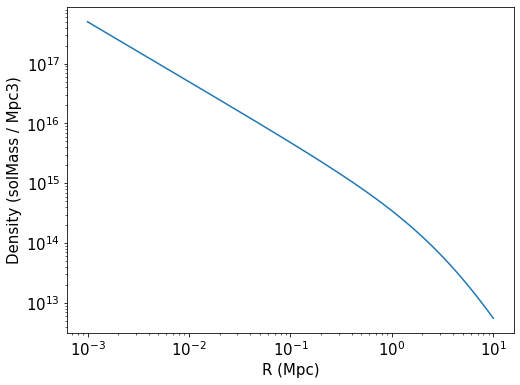

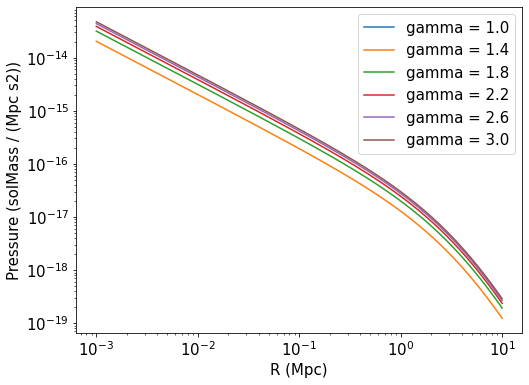

In [8]:
#for NFW model
alpha=1
beta=3
# free parameters a and rho_0
rho_0 = 10**14 * u.Msun/(u.Mpc)**3 
a=5 * u.Mpc#/cu.littleh 

rho=3*M/(4*np.pi*a**3)

nfw_potential = -4*np.pi*G*rho_0*a**2*(np.log(1+rs/a)/(rs/a))

nfw_density = rho_0/((rs/a)**alpha * (1+rs/a)**(beta-alpha))

nfw_gas = Gas(nfw_potential, nfw_density)
nfw_gas.plot()

In [9]:
rho_chi = nfw_density * 0.85


In [10]:
k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

In [5]:
#placeholder values
m_DM = 10**(-1) * u.GeV #change this to make the mass of DM particles different than mass of proton
sigma_0 = (10**-31 * (u.cm)**2).to(u.Mpc**2) #DM cross section, this is a placeholder value

In [14]:
# using the relation I came up with from GFE + Munoz, for constant pressure

def C(gamma): #total pressure and mass of cluster
    #C should have a negative sign in front, removed temporarily
    # restore k_B and do with temperature_energy equivalency
    C = (17* m_p**4 * sigma_0 * mu**(3/2) *(gamma-1)*(const.hbar*const.c)**(3/2))/((m_DM+m_p.to(u.GeV, equivalencies=u.mass_energy()))**2 * np.pi**(3/2)*k_B**(3/2))
        # removed k_B^3/2 from denominator to resolve units issue
    return C


In [15]:
#for a uniform density sphere of radius a
M=1*10**13 * u.Msun 
a=1 * u.Mpc#/cu.littleh 
rho=3*M/(4*np.pi*a**3)

#sph_density = np.piecewise(rs, [rs<=a, rs>a], [lambda rs: rho, lambda rs: 0])

In [16]:
Cs = C(1.4)
c1=0 #constant, define by boundary conditions

In [17]:
with u.set_enabled_equivalencies(u.mass_energy()):
    T_b = (0.5 * np.sqrt(Cs* rs**(-2) + c1)*const.c**2).to(u.eV, equivalencies=u.mass_energy())
    # ^ had to insert a factor of c^2 to resolve a units error

UnitConversionError: 'K(3/4) kg2 m(11/4) / (GeV s2)' and 'eV' (energy/torque/work) are not convertible

Text(0, 0.5, 'T_b (K)')

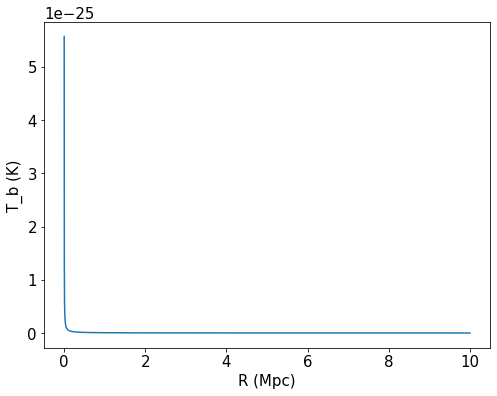

In [41]:
T_b = T_b.to(u.K, equivalencies=u.temperature_energy())
plt.plot(rs, T_b)
plt.xlabel(f'R ({rs.unit})')
plt.ylabel(f'T_b ({T_b.unit})')


Text(0, 0.5, 'T_b (K)')

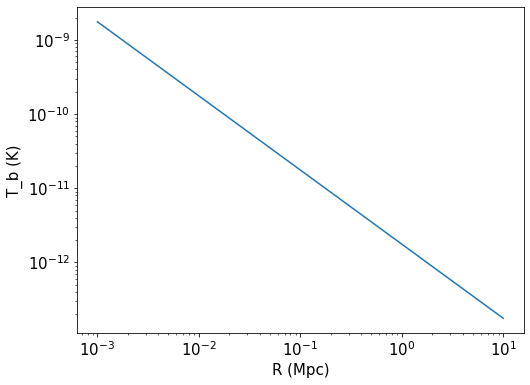

In [35]:
plt.loglog(rs, T_b)
plt.xlabel(f'R ({rs.unit})')
plt.ylabel(f'T_b ({T_b.unit})')